
this is a case study of the Bitcoin fluctuations in Euro value between 2019-01-01 and 2022-12-27 , using Python we study the serie and its characteristics, then parts relating to the treatment of non-stationarity, to the actual modeling of the stationary part, and to the forecast calculations for the studied serie for the period between 2022-12-28 and 2023-01-27

Importing the modules

In [9]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import numpy
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMAResults
import scipy.stats as stats
import pymannkendall as mk
import warnings

Getting the dataframe ready

In [10]:
df = pd.read_csv("BTC-EUR.csv")

In [43]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Avg
0,2019-01-01,3260.419922,3358.304932,3235.652832,3353.505859,3353.505859,3772904282,3296.978882
1,2019-01-02,3358.422119,3481.464111,3323.570313,3483.446045,3483.446045,4633091490,3402.517212
2,2019-01-03,3473.871582,3471.459229,3355.364014,3368.355713,3368.355713,3977171075,3413.411622
3,2019-01-04,3363.948730,3392.450439,3333.139893,3385.297607,3385.297607,4254278768,3362.795166
4,2019-01-05,3380.257324,3426.704834,3367.014160,3374.292725,3374.292725,4508432437,3396.859497
...,...,...,...,...,...,...,...,...
1452,2022-12-23,15875.133789,15921.419922,15859.444336,15746.622070,15746.622070,14370710930,15890.432129
1453,2022-12-24,15746.644531,15809.933594,15743.412109,15794.045898,15794.045898,9135177431,15776.672851
1454,2022-12-25,15793.811523,15806.043945,15777.098633,15857.252930,15857.252930,10974843059,15791.571289
1455,2022-12-26,15857.500000,15903.123047,15816.237305,15902.823242,15902.823242,11172480318,15859.680176


In [11]:
df['Date']= pd.to_datetime(df['Date'])

In [12]:
df['Avg'] = df[["High","Low"]].mean(axis=1)

Plotting the BTC-EUR price per date

<AxesSubplot:xlabel='Date'>

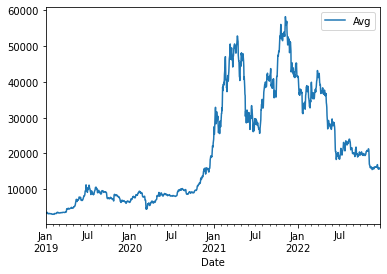

In [13]:
df.plot(x="Date",y="Avg")

Let's test the existence of a trend using Mann Kendall Test

In [14]:
mk.original_test(df.Avg)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=29.384856324458465, Tau=0.513836198118971, s=545024.0, var_s=344019069.3333333, slope=17.38522287792969, intercept=3226.7496393671863)

We can see that there is a trend. More, we can even say that there is a rift

Plotting the Simple and Partial Autocorrelation Functions

/opt/homebrew/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


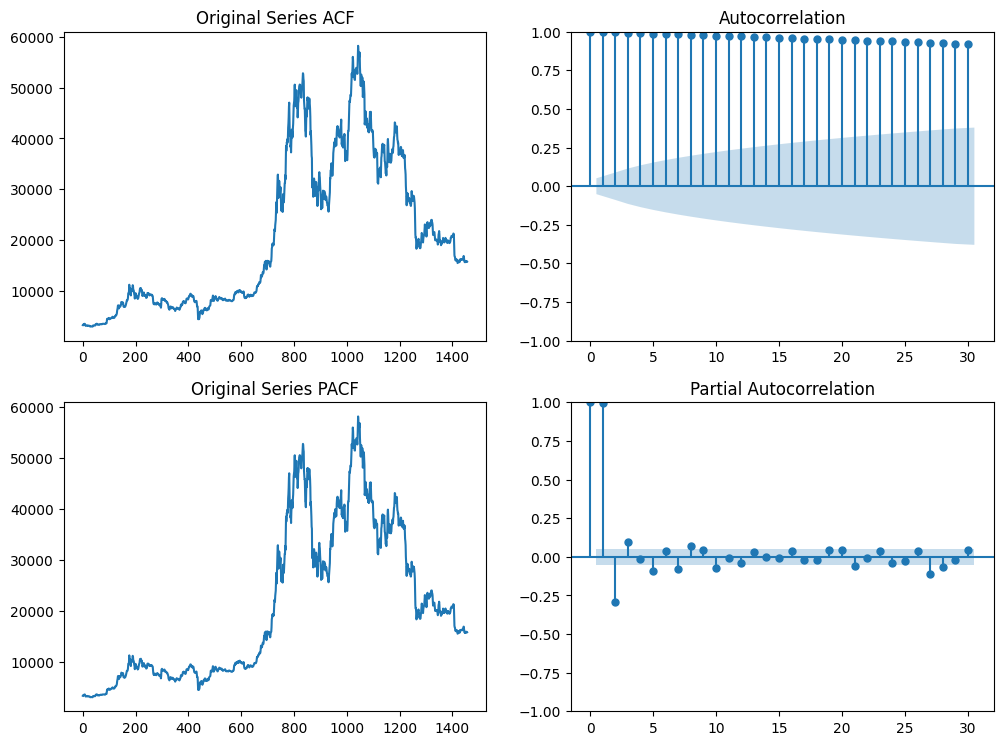

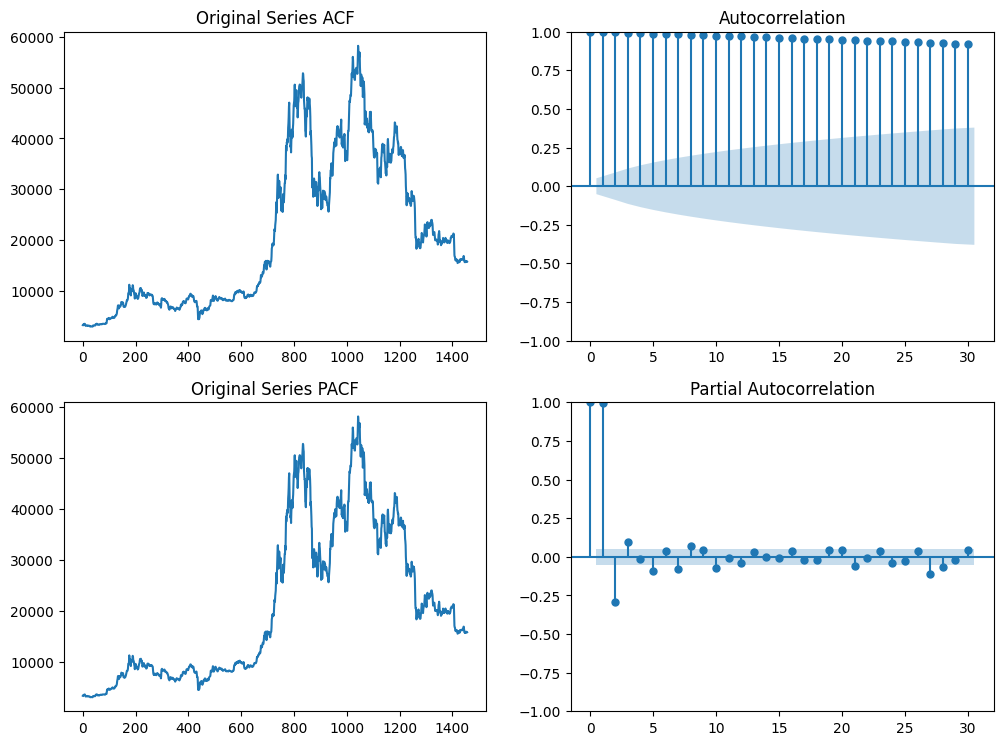

In [15]:
fig, axes = plt.subplots(2,2,figsize=(12,9), dpi=100)
axes[0,0].plot(df.Avg); axes[0,0].set_title('Original Series ACF')
plot_acf(df.Avg, ax = axes[0,1], lags = 30, alpha = 0.05 )
axes[1,0].plot(df.Avg); axes[1,0].set_title('Original Series PACF')
plot_pacf(df.Avg, ax = axes[1,1], lags = 30, alpha = 0.05)

Decomposing the Time Series usting STL

Period = 1 day

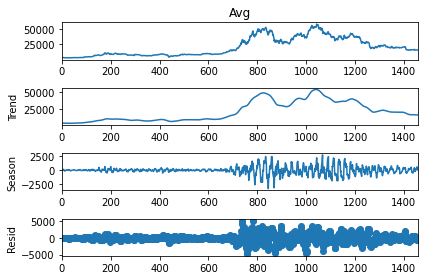

In [16]:
stl = STL(df.Avg, period=24)
res = stl.fit()
fig = res.plot()

Period = 1 week

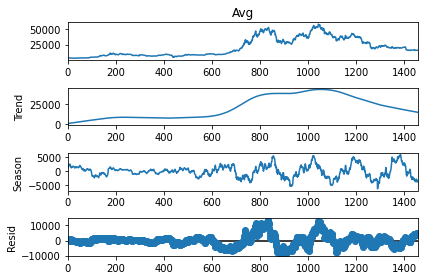

In [17]:
stl = STL(df.Avg, period=24*7)
res = stl.fit()
fig = res.plot()

Period = 1 Month

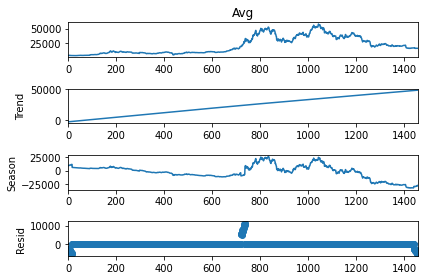

In [18]:
stl = STL(df.Avg, period=24*30)
res = stl.fit()
fig = res.plot()

In [19]:
result = adfuller(df.Avg)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.503719
p-value: 0.531671


Supposing the sample size infinite we get the critical value at 5% of : C = −3.41

and since :

        ADF Statistic > C

Also :

        p-value > 5%

Therefore we don't reject the non existence of a root unit.
        
Then the time series is non stationnary and we need to differentiate it.

Let's find the order d of differenciation

In [20]:
result = adfuller(df.Avg)
print("No differencing")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
result = adfuller(df.Avg.diff().dropna())
print("1st order differencing")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

No differencing
ADF Statistic: -1.503719
p-value: 0.531671
1st order differencing
ADF Statistic: -12.004521
p-value: 0.000000


Since:

        p-value < 5%

With first order differencing then the value of differenciation is d = 1

Let's find the order p of AR

/opt/homebrew/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


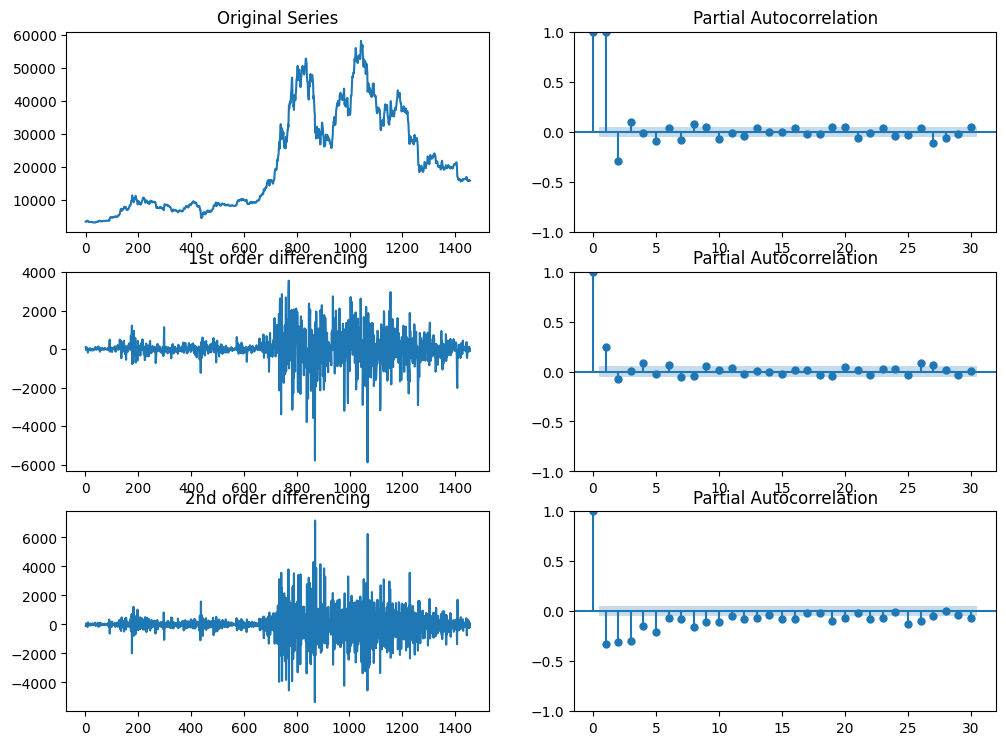

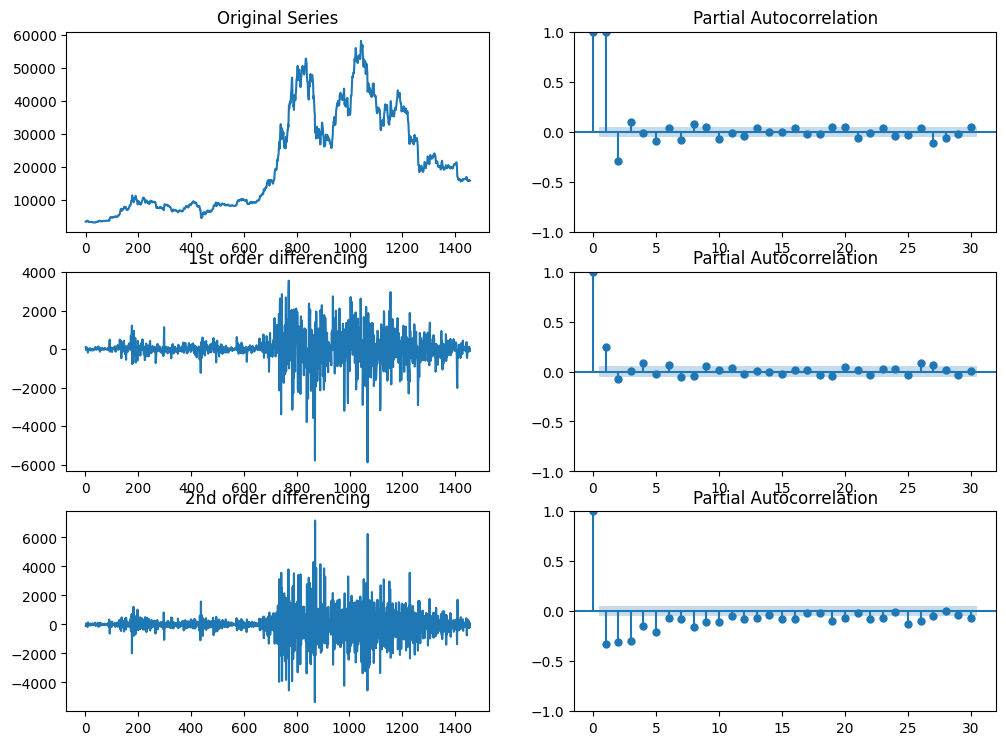

In [21]:
plt.rcParams.update({'figure.figsize':(12,8)})
#Original Series
fig, axes = plt.subplots(3,2,figsize=(12,9), dpi=100)
axes[0,0].plot(df.Avg); axes[0,0].set_title('Original Series')
plot_pacf(df.Avg, ax = axes[0,1], lags = 30, alpha = 0.05 )

#1st differencing 
axes[1,0].plot(df.Avg.diff()); axes[1,0].set_title('1st order differencing')
plot_pacf(df.Avg.diff().dropna(), ax = axes[1,1], lags = 30, alpha = 0.05 )

#2nd differencing
axes[2,0].plot(df.Avg.diff().diff()); axes[2,0].set_title('2nd order differencing')
plot_pacf(df.Avg.diff().diff().dropna(), ax = axes[2,1], lags = 30, alpha = 0.05 )

We take:

        p = 2

Let's find the order q of MA

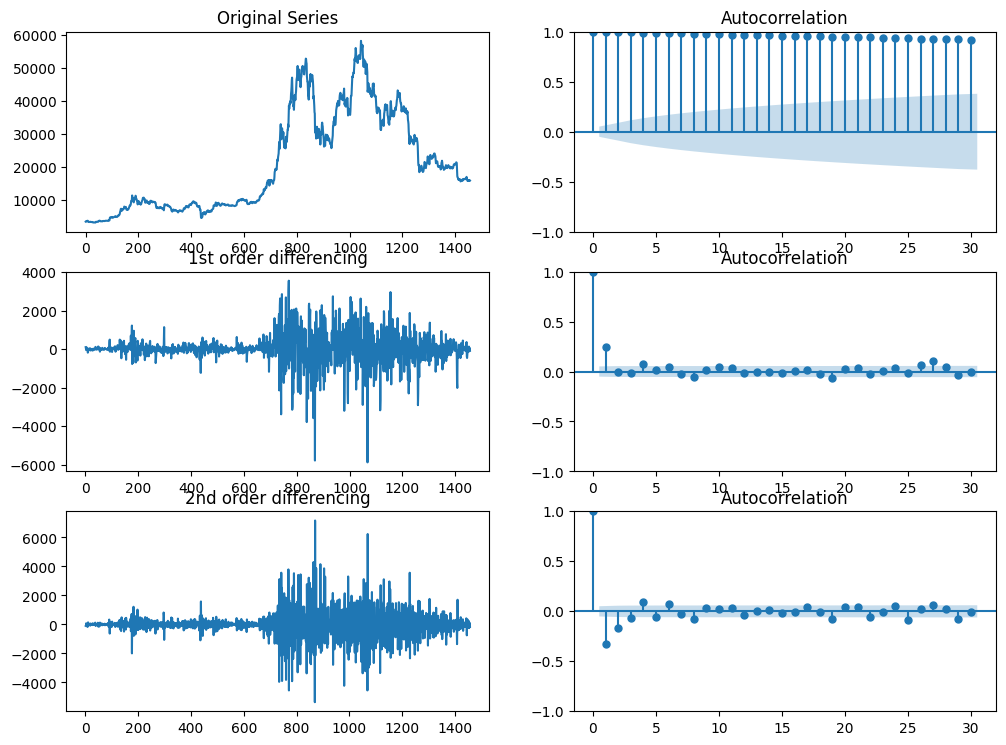

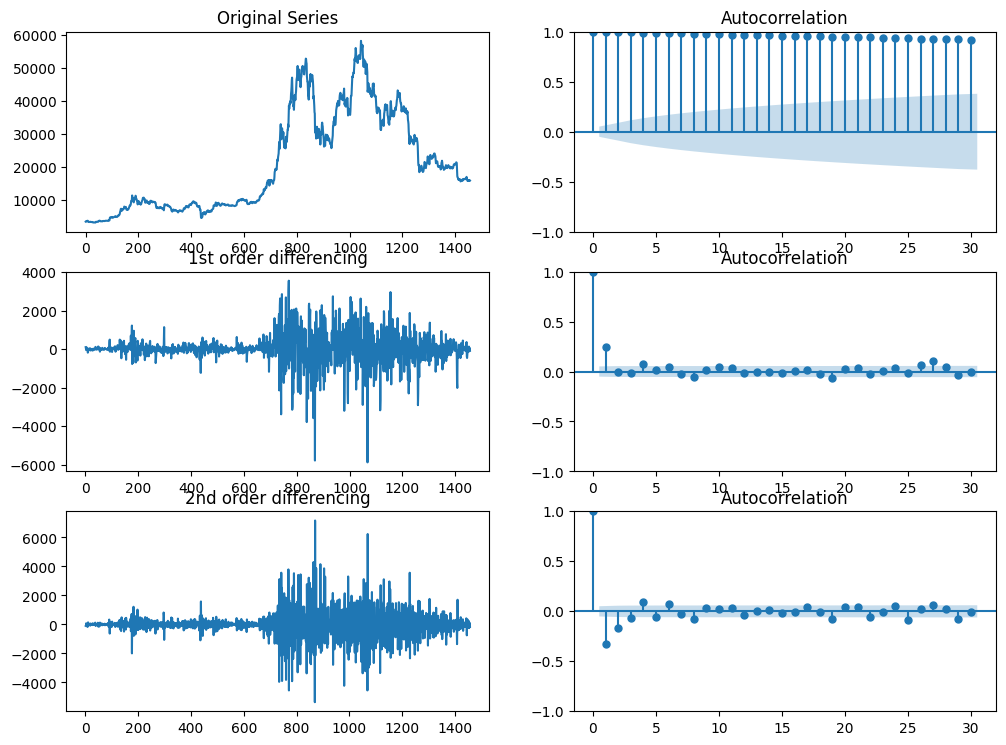

In [22]:
plt.rcParams.update({'figure.figsize':(12,8)})
#Original Series
fig, axes = plt.subplots(3,2,figsize=(12,9), dpi=100)
axes[0,0].plot(df.Avg); axes[0,0].set_title('Original Series')
plot_acf(df.Avg, ax = axes[0,1], lags = 30, alpha = 0.05 )

#1st differencing 
axes[1,0].plot(df.Avg.diff()); axes[1,0].set_title('1st order differencing')
plot_acf(df.Avg.diff().dropna(), ax = axes[1,1], lags = 30, alpha = 0.05 )

#2nd differencing
axes[2,0].plot(df.Avg.diff().diff()); axes[2,0].set_title('2nd order differencing')
plot_acf(df.Avg.diff().diff().dropna(), ax = axes[2,1], lags = 30, alpha = 0.05 )

We take:

        q = 2

ARIMA Model = (2,1,2) and here are the results

In [23]:
model = ARIMA(df.Avg, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    Avg   No. Observations:                 1457
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -11675.294
Date:                Tue, 07 Feb 2023   AIC                          23360.588
Time:                        02:22:09   BIC                          23387.006
Sample:                             0   HQIC                         23370.444
                               - 1457                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9155      0.066    -13.807      0.000      -1.046      -0.786
ar.L2         -0.2997      0.051     -5.869      0.000      -0.400      -0.200
ma.L1          1.1873      0.064     18.686      0.0

ARIMA Model = (1,1,1) and here are the results

In [24]:
model_2 = ARIMA(df.Avg, order=(1,1,1))
model_fit_2 = model_2.fit()
print(model_fit_2.summary())

                               SARIMAX Results                                
Dep. Variable:                    Avg   No. Observations:                 1457
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11684.153
Date:                Tue, 07 Feb 2023   AIC                          23374.306
Time:                        02:22:11   BIC                          23390.156
Sample:                             0   HQIC                         23380.219
                               - 1457                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0476      0.069      0.693      0.488      -0.087       0.182
ma.L1          0.2193      0.067      3.260      0.001       0.087       0.351
sigma2      5.479e+05   9387.683     58.364      0.0

For the residuals

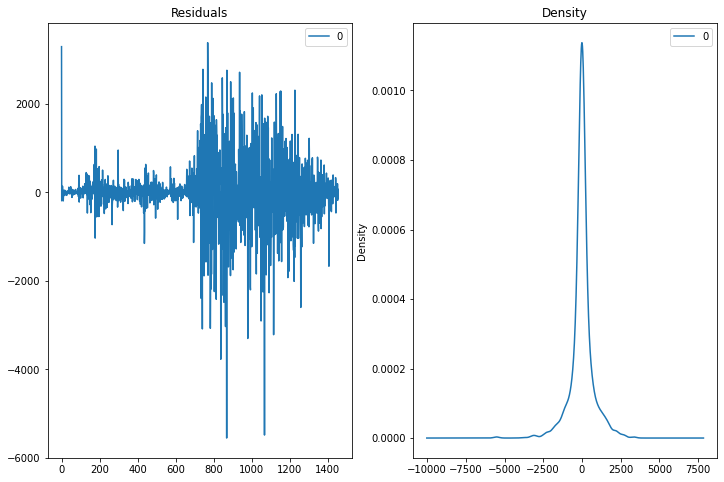

In [25]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals",ax = ax[0])
residuals.plot(kind='kde',title= 'Density', ax=ax[1])
plt.show()

Ljung-Box Test

In [26]:
acorr_ljungbox(residuals, lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,0.041714,0.838166


Since :

        p-value > 5%

Then we don't reject the null hypothesis of the correlation of residuals

Heteroskedasticity Test

In [27]:
test_hetero = ARIMAResults.test_heteroskedasticity(model_fit,method=None)
print("p-value : ",test_hetero[0][1])

p-value :  1.9704763267579508e-161


Since:

    p-value < 5%

We reject the null hypothese of the homoskedasticity of residuals.

Which means that there exists heteroskedasticity between the residuals

Normality Test

In [28]:
stats.jarque_bera(residuals)

Jarque_beraResult(statistic=3719.681858270043, pvalue=0.0)

From this test we ca conclude that the residuals don't follow normality

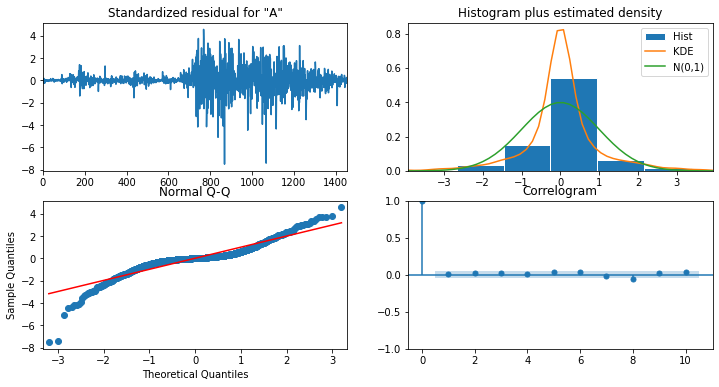

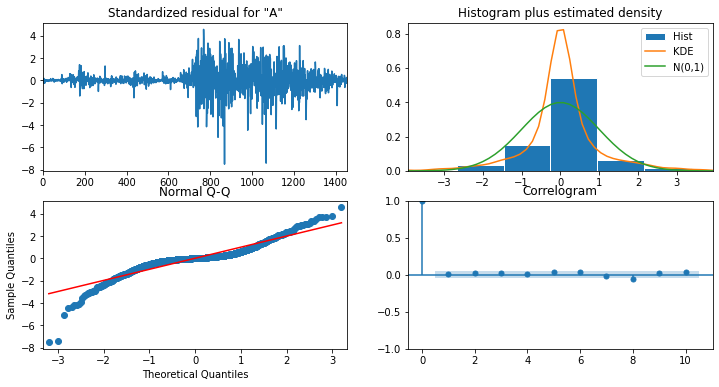

In [29]:
model_fit.plot_diagnostics(figsize=(12,6))

In [30]:
train = list(df.Avg[:1300])
test = list(df.Avg[1300:])
model_predictions = []

In [31]:
warnings.filterwarnings('ignore')
n = len(test)
for i in range(n):
  model = ARIMA(train, order=(2,1,2))
  fitted = model.fit()
  fc = fitted.forecast()
  model_predictions.append(fc)
  actual = test[i]
  train.append(actual)

In [32]:
model_predictions = [model_predictions[i][0] for i in range(n)]

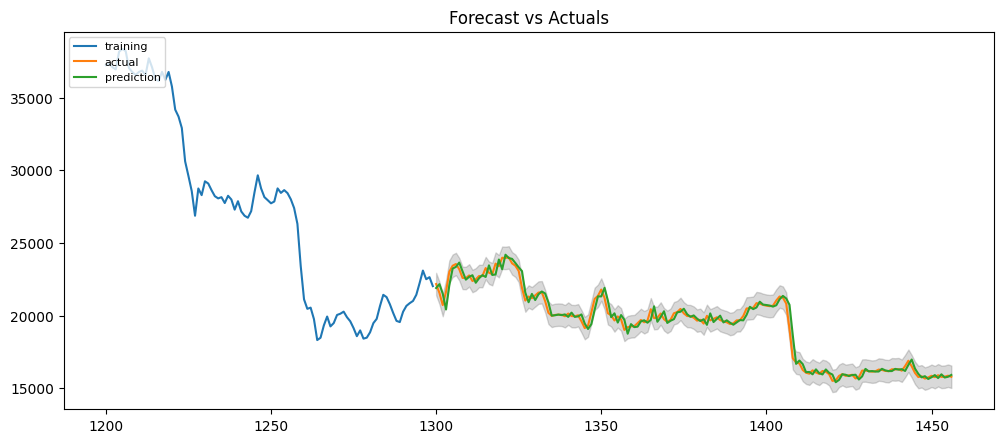

In [33]:
residuals = [df.Avg[1300+i] - model_predictions[i] for i in range(n)]
fc_series = pd.Series(np.array(model_predictions), index=df.Avg[1300:].index)
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE
lower_series = pd.Series(test-band_size, index=df.Avg[1300:].index)
upper_series = pd.Series(test+band_size, index=df.Avg[1300:].index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df.Avg[1200:1300], label='training')
plt.plot(df.Avg[1300:], label='actual')
plt.plot(fc_series, label='prediction')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [34]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    Avg   No. Observations:                 1457
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -11675.294
Date:                Tue, 07 Feb 2023   AIC                          23360.588
Time:                        02:22:35   BIC                          23387.006
Sample:                             0   HQIC                         23370.444
                               - 1457                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9155      0.066    -13.807      0.000      -1.046      -0.786
ar.L2         -0.2997      0.051     -5.869      0.000      -0.400      -0.200
ma.L1          1.1873      0.064     18.686      0.0

In [35]:
from sklearn import metrics

me = np.mean(df.Avg[1300:] - model_predictions)
mae = metrics.mean_absolute_error(df.Avg[1300:], model_predictions)
mse = metrics.mean_squared_error(df.Avg[1300:], model_predictions)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(df.Avg[1300:], model_predictions)
corr = np.corrcoef(model_predictions,df.Avg[1300:])[0,1]
r2 = metrics.r2_score(df.Avg[1300:], model_predictions)

print("Results of sklearn.metrics:")
print("ME:",me)
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:",mape)
print("Corr", corr)
print("R-Squared:", r2)

Results of sklearn.metrics:
ME: -31.906930416714037
MAE: 274.351324115927
MSE: 155619.26703571988
RMSE: 394.4860796475839
MAPE: 0.013909610124452798
Corr 0.9874574581307497
R-Squared: 0.9747471657924417


Let's try another model suggested by auto ARIMA and see how different it is in out-of-time cross validation

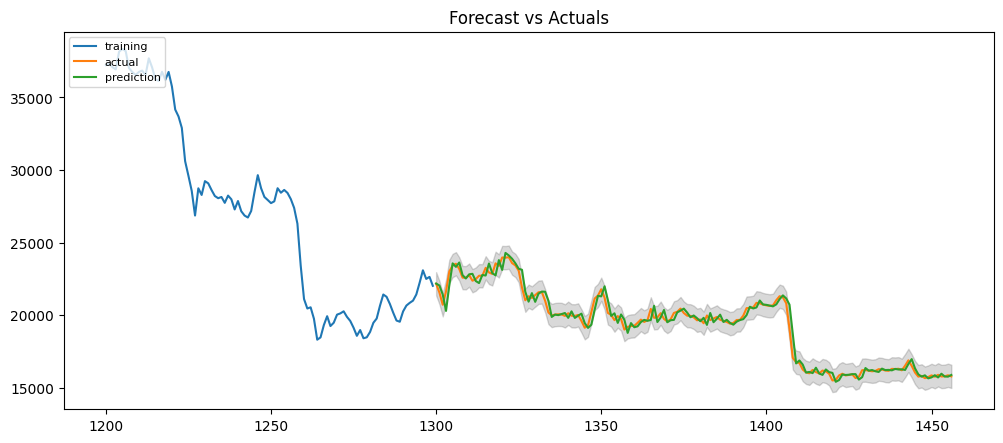

Results of sklearn.metrics:
ME: -33.703159015881454
MAE: 281.8966632836441
MSE: 167743.69600385704
RMSE: 409.5652524370897
MAPE: 0.014287360909745717
Corr 0.9865281089025973
R-Squared: 0.9727796960798167


In [36]:
train = list(df.Avg[:1300])
test = list(df.Avg[1300:])
model_predictions = []
n = len(test)
for i in range(n):
  model = ARIMA(train, order=(4,1,5))
  fitted = model.fit()
  fc = fitted.forecast()
  model_predictions.append(fc)
  actual = test[i]
  train.append(actual)
model_predictions = [model_predictions[i][0] for i in range(n)]
residuals = [df.Avg[1300+i] - model_predictions[i] for i in range(n)]
fc_series = pd.Series(np.array(model_predictions), index=df.Avg[1300:].index)
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE
lower_series = pd.Series(test-band_size, index=df.Avg[1300:].index)
upper_series = pd.Series(test+band_size, index=df.Avg[1300:].index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df.Avg[1200:1300], label='training')
plt.plot(df.Avg[1300:], label='actual')
plt.plot(fc_series, label='prediction')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
me = np.mean(df.Avg[1300:] - model_predictions)
mae = metrics.mean_absolute_error(df.Avg[1300:], model_predictions)
mse = metrics.mean_squared_error(df.Avg[1300:], model_predictions)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(df.Avg[1300:], model_predictions)
corr = np.corrcoef(model_predictions,df.Avg[1300:])[0,1]
r2 = metrics.r2_score(df.Avg[1300:], model_predictions)

print("Results of sklearn.metrics:")
print("ME:",me)
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:",mape)
print("Corr", corr)
print("R-Squared:", r2)

In [37]:
n = 31
data = list(df.Avg)
model_predictions_2 = []
for i in range(n):
  model = ARIMA(np.array(data), order=(2,1,2))
  fitted = model.fit()
  fc = fitted.forecast()
  model_predictions_2.append(fc[0])
  data.append(fc[0])

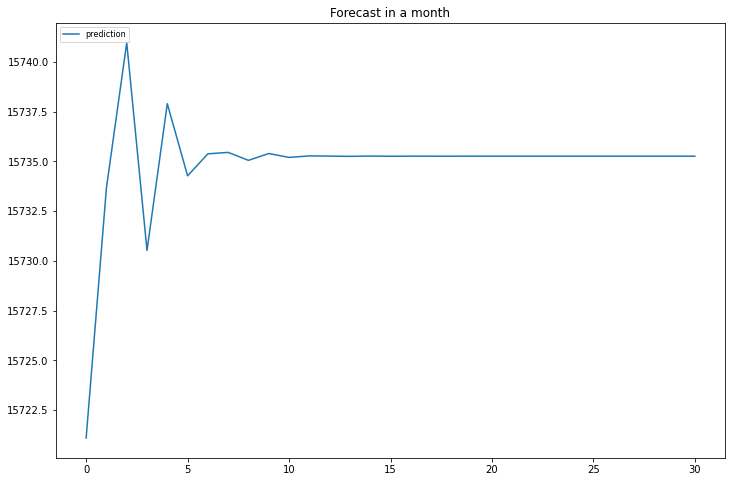

In [38]:
fc_series = pd.Series(np.array(model_predictions_2))
plt.plot(fc_series, label='prediction')
plt.title('Forecast in a month')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [39]:
from pmdarima.arima import auto_arima

In [40]:
model = auto_arima(df.Avg, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23376.196, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23472.693, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23380.708, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23374.537, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23470.876, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=23376.078, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23369.623, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23362.511, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23376.909, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=23362.566, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=23359.740, Time=0.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=23365.634, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=23363.741, Time=0.61 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=23365.335, Time=0.65 sec
 ARIMA(1,1,4)(0,0,0

In [41]:
prediction, confint = model.predict(n_periods=31, return_conf_int=True)

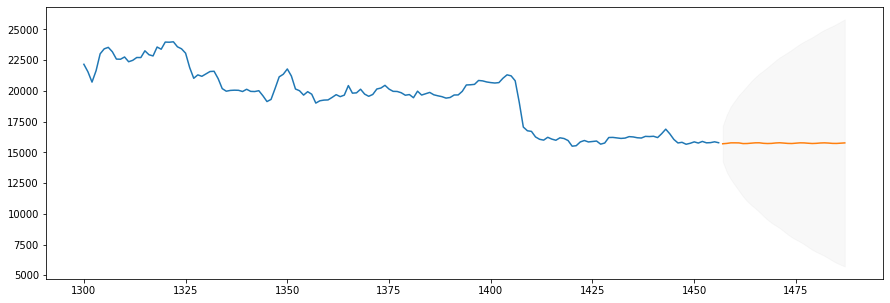

In [42]:
cf= pd.DataFrame(confint)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df.Avg[1300:])
ax.plot(prediction)
ax.fill_between(prediction.index,
                cf[0],
                cf[1],color='grey',alpha=.05)